In [ ]:
import sys
print(sys.executable)

# appends root to PATH so notebook can find include modules
sys.path.append('../')

# this prevents the need to restart the kernel every time a local module is changed
%load_ext autoreload
%autoreload 2

/data/sguotong/micromamba/envs/cage/bin/python


In [ ]:
from include.bessel import initialize_bessel_table, BesselJZeros, BesselJpZeros
initialize_bessel_table(10, 10)

# print out a table of BesselJZeros
print("BesselJZeros (m,n): \n")
print("k |  J_0(x) |  J_1(x) |  J_2(x) |  J_3(x) |  J_4(x) |  J_5(x) |\n")
for n in range(1, 6):
    str_out = f"{n} |"
    for m in range(0, 6):
        str_out += f" {BesselJZeros(m, n):.5f} |"

    print(str_out)

print("\n https://mathworld.wolfram.com/BesselFunctionZeros.html")

BesselJZeros (m,n): 

k |  J_0(x) |  J_1(x) |  J_2(x) |  J_3(x) |  J_4(x) |  J_5(x) |

1 | 2.40483 | 3.83171 | 5.13562 | 6.38016 | 7.58834 | 8.77148 |
2 | 5.52008 | 7.01559 | 8.41724 | 9.76102 | 11.06471 | 12.33860 |
3 | 8.65373 | 10.17347 | 11.61984 | 13.01520 | 14.37254 | 15.70017 |
4 | 11.79153 | 13.32369 | 14.79595 | 16.22347 | 17.61597 | 18.98013 |
5 | 14.93092 | 16.47063 | 17.95982 | 19.40942 | 20.82693 | 22.21780 |

 https://mathworld.wolfram.com/BesselFunctionZeros.html


In [ ]:
import pyvista as pv
import numpy as np
from pathlib import Path

from include.custom_types import *
from include.cavity_modes import *

def plot_E(
        a: f64, L: f64, 
        Nr, Nphi, Nz, 
        fam: Family, m: int, n: int, p: int, 
        fig_dir: str | Path,
        *,
        in_notebook = False
    ):
    """
    This function plots the electric field of a cylindrical cavity mode using PyVista.
    Plots imaginary part for TE modes and real part for TM modes.
    Plots the + field on the 3D cylinder on the left and the - field as stacked circular cross-sections on the right.
    Parameters:
        a (float): Cavity radius.
        L (float): Cavity length.
        Nr (int): Number of radial points.
        Nphi (int): Number of azimuthal points.
        Nz (int): Number of axial points.
        fam (Family): Family of the mode (TE or TM).
        m (int): Azimuthal mode number.
        n (int): Radial mode number.
        p (int): Axial mode number.
        fig_dir (str | os.PathLike): Directory to save the figure.
        in_notebook (bool, optional): If True, show the plot in a notebook. Defaults to False.
    """
    if fam == "TE" and (m == 0 or p == 0):
        print("Skipping unphysical TE_0n0 mode")
        return
    # create cylinder mesh
    r = np.linspace(0.0, a, Nr)
    mesh_p = pv.CylinderStructured(radius=r, height=L, center=(0.0,0.0,0.0), direction=(0.0, 0.0, 1.0),     # type: ignore
                                theta_resolution=Nphi-1, z_resolution=Nz)
    mesh_m = mesh_p.copy()
    # get mesh point coordinates
    cartesian_points = mesh_p.points
    x = cartesian_points[:, 0]
    y = cartesian_points[:, 1]
    z_flat = cartesian_points[:, 2]
    r_flat = np.sqrt(x**2 + y**2)
    phi_flat = np.arctan2(y, x)

    # calculate mode frequency and Q
    w_mnp = omega_mnp(a, L, fam, m, n, p)
    f_mnp = w_mnp/(2*np.pi)*0.3         # in GHz
    Q_mnp_2Rs = Q_mnp_times_2Rs(a, L, fam, m, n, p)
    # compute both + and - fields on mesh grid
    shape = (Nr, Nphi, Nz)
    R3, PHI3, Z3 = np.reshape(r_flat, shape, order='F'), np.reshape(phi_flat, shape, order='F'), np.reshape(z_flat, shape, order='F')
    Er_p, Ephi_p, Ez_p = E_mnp(a, L, R3, PHI3, Z3, fam, m, n, p, "+")
    Er_m, Ephi_m, Ez_m = E_mnp(a, L, R3, PHI3, Z3, fam, m, n, p, "-")
    #   get the real/imag component based on family
    if fam == "TE":
        # pyvista expects Fortran-order flattening
        Er_pf, Ephi_pf, Ez_pf = np.imag(Er_p).ravel(order='F'), np.imag(Ephi_p).ravel(order='F'), np.imag(Ez_p).ravel(order='F')
        Er_mf, Ephi_mf, Ez_mf = np.imag(Er_m).ravel(order='F'), np.imag(Ephi_m).ravel(order='F'), np.imag(Ez_m).ravel(order='F')
    else:
        Er_pf, Ephi_pf, Ez_pf = np.real(Er_p).ravel(order='F'), np.real(Ephi_p).ravel(order='F'), np.real(Ez_p).ravel(order='F')
        Er_mf, Ephi_mf, Ez_mf = np.real(Er_m).ravel(order='F'), np.real(Ephi_m).ravel(order='F'), np.real(Ez_m).ravel(order='F')
    #   convert (Er, Ephi) -> (Ex, Ey) for plotting
    sp, cp = np.sin(phi_flat), np.cos(phi_flat)
    Ex_pf = Er_pf * cp - Ephi_pf * sp
    Ey_pf = Er_pf * sp + Ephi_pf * cp
    Ex_mf = Er_mf * cp - Ephi_mf * sp
    Ey_mf = Er_mf * sp + Ephi_mf * cp

    # make side-by-side plots for +/- fields
    plotter = pv.Plotter(shape=(1,2))
    #   + field on the left
    plotter.subplot(0, 0)
    plotter.add_title(f'{fam}{m}{n}{p}+', font='times')
    plotter.add_text(f"f = {f_mnp:.2f} GHz", 
                     font="times", font_size=10, position=(20,600))
    plotter.add_text(f"Q = {Q_mnp_2Rs:.2f}", 
                     font="times", font_size=10, position=(20,550))
    
    plotter.add_axes()  # type: ignore
    #       add point datas to the + mesh
    mesh_p.point_data['Ex_3D'] = Ex_pf
    mesh_p.point_data['Ey_3D'] = Ey_pf
    mesh_p.point_data['Ez_3D'] = Ez_pf
    Evec_p = np.vstack((Ex_pf, Ey_pf, Ez_pf)).T
    norm_p = np.linalg.norm(Evec_p, axis=1)
    max_norm_p = np.max(norm_p)
    mesh_p.point_data['magnitude'] = norm_p/max_norm_p
    mesh_p.point_data['vec3D'] = Evec_p
    mesh_p.set_active_vectors('vec3D')
    mesh_p.set_active_scalars('magnitude')
    #       plot entire cavity
    plotter.add_mesh(mesh_p, scalars='magnitude', cmap='haline', show_scalar_bar=True, scalar_bar_args={'title': '|E+|', 'fmt': '%.1f', 'font_family': 'times'})

    #   show slices for the - field
    plotter.subplot(0, 1)
    plotter.add_title(f'{fam}{m}{n}{p}-', font='times')
    plotter.add_axes()  # type: ignore
    mesh_m.point_data['Ex_3D'] = Ex_mf
    mesh_m.point_data['Ey_3D'] = Ey_mf
    mesh_m.point_data['Ez_3D'] = Ez_mf
    Evec_m = np.vstack((Ex_mf, Ey_mf, Ez_mf)).T
    norm_m = np.linalg.norm(Evec_m, axis=1)
    max_norm_m = np.max(norm_m)
    mesh_m.point_data['magnitude'] = norm_m/max_norm_m
    mesh_m.point_data['vec3D'] = Evec_m
    mesh_m.set_active_vectors('vec3D')
    mesh_m.set_active_scalars('magnitude')
    slices = mesh_m.slice_along_axis(n=9, axis='z')
    plotter.add_mesh(slices, cmap='haline', show_scalar_bar=True, scalar_bar_args={'title': '|E-|', 'fmt': '%.1f', 'font_family': 'times'})

    if in_notebook:
        plotter.show()
    else:
        fig_name = Path(fig_dir) / f"{fam}{m}{n}{p}.pdf"
        plotter.save_graphic(fig_name, raster=False)  # type: ignore

/data/sguotong/micromamba/envs/cage/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/data/sguotong/micromamba/envs/cage/lib/python3.13/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


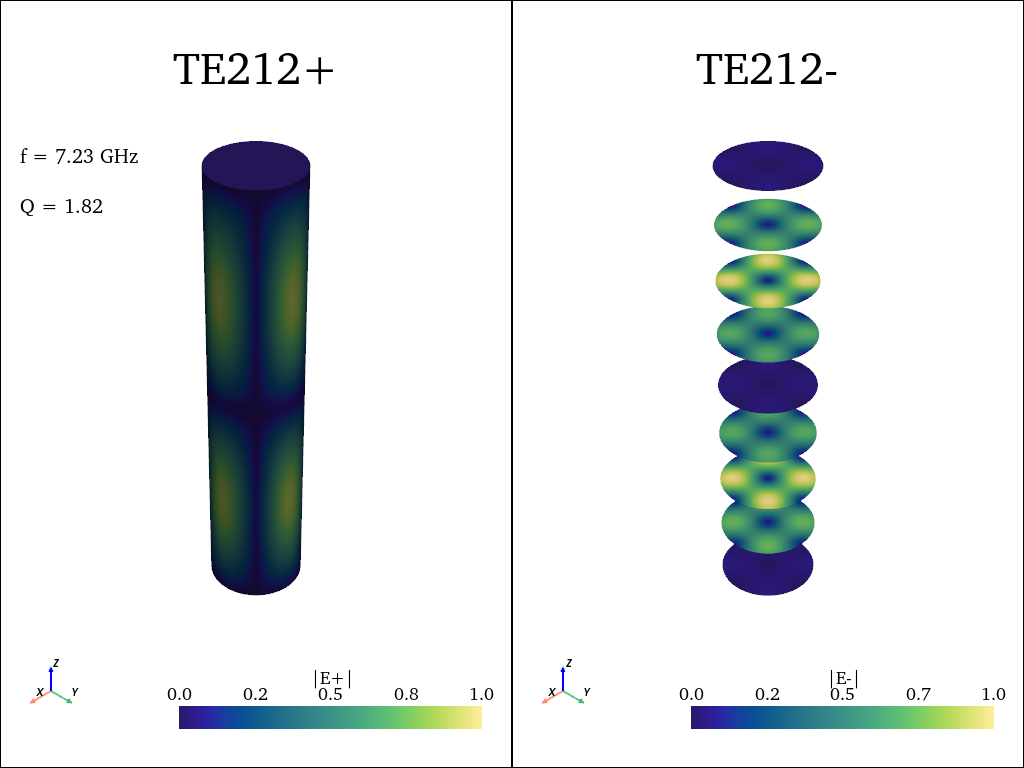

In [ ]:
from itertools import product

a, L = 0.0206, 0.2032
Nr, Nphi, Nz = 30, 90, 50

families = ["TE", "TM"]
m_vals = [0, 1, 2]
n_vals = [1, 2]
p_vals = [0, 1, 2]
combos = list(product(families, m_vals, n_vals, p_vals))

fig_dir = '/data/sguotong/projects/CaGe/figs'

# for (fam, m, n, p) in combos:
#     plot_E(a, L, Nr, Nphi, Nz, fam, m, n, p, fig_dir)

# print(f"Saved figs to {fig_dir}.")


fam, m, n, p = "TE", 2, 1, 2
plot_E(a, L, Nr, Nphi, Nz, fam, m, n, p, fig_dir, in_notebook=True)

In [ ]:
def plot_E_slice(
        a: f64, L: f64, 
        Nr, Nphi, Nz, 
        fam: Family, m: int, n: int, p: int, 
        fig_dir: str | Path,
        *,
        in_notebook = False
    ):
    if fam == "TE" and (m == 0 or p == 0):
        print("Skipping unphysical TE_0n0 mode")
        return
    # create 2 meshes for the +/- fields
    r = np.linspace(0.0, a, Nr)
    mesh = pv.CylinderStructured(radius=r, height=L, center=(0.0,0.0,0.0), direction=(0.0, 0.0, 1.0),     # type: ignore
                                theta_resolution=Nphi-1, z_resolution=Nz)
    # get mesh point coordinates on the slices
    mesh_p, mesh_m = mesh.copy().slice(normal=[0,0,1], origin=[0,0,0.01*L]), mesh.copy().slice(normal=[0,0,1], origin=[0,0,0.01*L])
    cartesian_points = mesh_p.points
    x = cartesian_points[:, 0]
    y = cartesian_points[:, 1]
    z_flat = cartesian_points[:, 2]
    r_flat = np.sqrt(x**2 + y**2)
    phi_flat = np.arctan2(y, x)

    # compute E fields on the slices
    shape = (Nr, Nphi)
    R3, PHI3, Z3 = np.reshape(r_flat, shape, order='F'), np.reshape(phi_flat, shape, order='F'), np.reshape(z_flat, shape, order='F')
    Er_p, Ephi_p, Ez_p = E_mnp(a, L, R3, PHI3, Z3, fam, m, n, p, "+")
    Er_m, Ephi_m, Ez_m = E_mnp(a, L, R3, PHI3, Z3, fam, m, n, p, "-")
    #   get the real/imag component based on family
    if fam == "TE":
        # pyvista expects Fortran-order flattening
        Er_pf, Ephi_pf, Ez_pf = np.imag(Er_p).ravel(order='F'), np.imag(Ephi_p).ravel(order='F'), np.imag(Ez_p).ravel(order='F')
        Er_mf, Ephi_mf, Ez_mf = np.imag(Er_m).ravel(order='F'), np.imag(Ephi_m).ravel(order='F'), np.imag(Ez_m).ravel(order='F')
    else:
        Er_pf, Ephi_pf, Ez_pf = np.real(Er_p).ravel(order='F'), np.real(Ephi_p).ravel(order='F'), np.real(Ez_p).ravel(order='F')
        Er_mf, Ephi_mf, Ez_mf = np.real(Er_m).ravel(order='F'), np.real(Ephi_m).ravel(order='F'), np.real(Ez_m).ravel(order='F')
    #   convert (Er, Ephi) -> (Ex, Ey) for plotting
    sp, cp = np.sin(phi_flat), np.cos(phi_flat)
    Ex_pf = Er_pf * cp - Ephi_pf * sp
    Ey_pf = Er_pf * sp + Ephi_pf * cp
    Ex_mf = Er_mf * cp - Ephi_mf * sp
    Ey_mf = Er_mf * sp + Ephi_mf * cp

    
    # make side-by-side plots for +/- fields
    plotter = pv.Plotter(shape=(1,2))
    #   + field on the left
    plotter.subplot(0, 0)
    plotter.add_title(f'{fam}{m}{n}{p}+', font='times')
    plotter.add_axes()  # type: ignore
    #       add point datas to the + mesh
    mesh_p.point_data['Ex_2D'] = Ex_pf
    mesh_p.point_data['Ey_2D'] = Ey_pf
    mesh_p.point_data['Ez_2D'] = Ez_pf
    Evec_p = np.vstack((Ex_pf, Ey_pf, Ez_pf)).T
    norm_p = np.linalg.norm(Evec_p, axis=1)
    max_norm_p = np.max(norm_p)
    mesh_p.point_data['magnitude'] = norm_p/max_norm_p
    mesh_p.point_data['vec2D'] = Evec_p
    mesh_p.set_active_vectors('vec2D')
    mesh_p.set_active_scalars('magnitude')
    #       plot entire cavity
    plotter.add_mesh(mesh_p, scalars='magnitude', cmap='haline', show_scalar_bar=True,      # type: ignore
                     scalar_bar_args={'title': '|E+|', 'fmt': '%.1f', 'font_family': 'times'})
    arrows_p = mesh_p.glyph(orient='vec2D', scale=False, factor=0.002, tolerance=0.03)
    plotter.add_mesh(arrows_p, color='black', show_scalar_bar=False)


    #   do the same for - field
    plotter.subplot(0, 1)
    plotter.add_title(f'{fam}{m}{n}{p}-', font='times')
    plotter.add_axes()  # type: ignore
    mesh_m.point_data['Ex_2D'] = Ex_mf
    mesh_m.point_data['Ey_2D'] = Ey_mf
    mesh_m.point_data['Ez_2D'] = Ez_mf
    Evec_m = np.vstack((Ex_mf, Ey_mf, Ez_mf)).T
    norm_m = np.linalg.norm(Evec_m, axis=1)
    max_norm_m = np.max(norm_m)
    mesh_m.point_data['magnitude'] = norm_m/max_norm_m
    mesh_m.point_data['vec2D'] = Evec_m
    mesh_m.set_active_vectors('vec2D')
    mesh_m.set_active_scalars('magnitude')
    #       plot entire cavity
    plotter.add_mesh(mesh_m, scalars='magnitude', cmap='haline', show_scalar_bar=True,   # type: ignore
                     scalar_bar_args={'title': '|E-|', 'fmt': '%.1f', 'font_family': 'times'})
    arrows_m = mesh_m.glyph(orient='vec2D', scale=False, factor=0.002, tolerance=0.03)
    plotter.add_mesh(arrows_m, color='black', show_scalar_bar=False)

    if in_notebook:
        plotter.show()
    else:
        fig_name = Path(fig_dir) / f"{fam}{m}{n}{p}_slice.pdf"
        plotter.save_graphic(fig_name, raster=False)  # type: ignore

/data/sguotong/micromamba/envs/cage/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/data/sguotong/micromamba/envs/cage/lib/python3.13/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


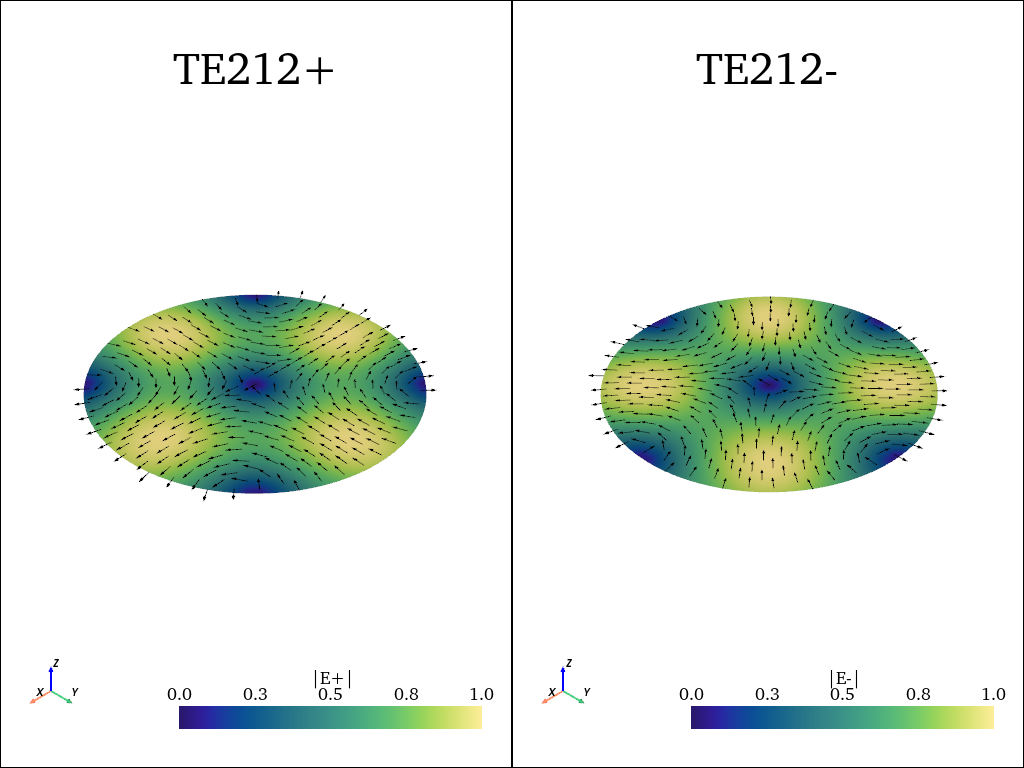

In [ ]:
fam, m, n, p = "TE", 2, 1, 2
plot_E_slice(a, L, Nr, Nphi, Nz, fam, m, n, p, fig_dir, in_notebook=True)

In [ ]:
import pyvista as pv
import numpy as np
from pathlib import Path

from include.custom_types import *

def plot_J(
        a: f64, L: f64, 
        j_dir: Path, beta_str: str,
        fig_dir: str | Path,
        *,
        in_notebook = False
    ):
    Jr_p = np.load(j_dir / f"Jr_p_{beta_str}.npy")[...,0,0,0]
    Jphi_p = np.load(j_dir / f"Jr_p_{beta_str}.npy")[...,0,0,0]
    Jz_p = np.load(j_dir / f"Jr_p_{beta_str}.npy")[...,0,0,0]

    Jr_c = np.load(j_dir / f"Jr_c_{beta_str}.npy")[...,0,0,0]
    Jphi_c = np.load(j_dir / f"Jr_c_{beta_str}.npy")[...,0,0,0]
    Jz_c = np.load(j_dir / f"Jr_c_{beta_str}.npy")[...,0,0,0]

    Nr, Nphi, Nz = Jr_p.shape[0], Jr_p.shape[1], Jr_p.shape[2]

    r = np.linspace(0.0, a, Nr)
    mesh = pv.CylinderStructured(radius=r, height=L, center=(0.0,0.0,0.0), direction=(0.0, 0.0, 1.0),     # type: ignore
                                theta_resolution=Nphi-1, z_resolution=Nz)
    mesh_c = mesh.copy()
    cartesian_points = mesh.points
    x = cartesian_points[:, 0]
    y = cartesian_points[:, 1]
    phi_flat = np.mod(np.arctan2(y, x), 2*np.pi)

    Jr_pf, Jphi_pf, Jz_pf = np.real(Jr_p).ravel(order='F'), np.real(Jphi_p).ravel(order='F'), np.real(Jz_p).ravel(order='F')
    Jr_cf, Jphi_cf, Jz_cf = np.real(Jr_c).ravel(order='F'), np.real(Jphi_c).ravel(order='F'), np.real(Jz_c).ravel(order='F')

    sp, cp = np.sin(phi_flat), np.cos(phi_flat)
    Jx_pf = Jr_pf * cp - Jphi_pf * sp
    Jy_pf = Jr_pf * sp + Jphi_pf * cp
    Jx_cf = Jr_cf * cp - Jphi_cf * sp
    Jy_cf = Jr_cf * sp + Jphi_cf * cp

    # make side-by-side plots for plus/cross currents
    plotter = pv.Plotter(shape=(1,2))

    plotter.subplot(0, 0)
    plotter.add_title('|j_plus|', font='times')
    plotter.add_axes()  # type: ignore
    #       add point datas to the + mesh
    mesh.point_data['Jx'] = Jx_pf
    mesh.point_data['Jy'] = Jy_pf
    mesh.point_data['Jz'] = Jz_pf
    Jvec = np.vstack((Jx_pf, Jy_pf, Jz_pf)).T
    norm = np.linalg.norm(Jvec, axis=1)
    max_norm = np.max(norm)
    mesh.point_data['magnitude'] = norm/max_norm
    mesh.point_data['vec'] = Jvec
    mesh.set_active_vectors('vec')
    mesh.set_active_scalars('magnitude')
    plotter.add_mesh(mesh, scalars='magnitude', cmap='haline', show_scalar_bar=True, scalar_bar_args={'title': '|j+|', 'fmt': '%.1f', 'font_family': 'times'})

    plotter.subplot(0, 1)
    plotter.add_title('|j_cross|', font='times')
    plotter.add_axes()  # type: ignore
    #       add point datas to the + mesh
    mesh_c.point_data['Jx'] = Jx_cf
    mesh_c.point_data['Jy'] = Jy_cf
    mesh_c.point_data['Jz'] = Jz_cf
    Jvec_c = np.vstack((Jx_cf, Jy_cf, Jz_cf)).T
    norm_c = np.linalg.norm(Jvec_c, axis=1)
    max_norm_c = np.max(norm_c)
    mesh_c.point_data['magnitude'] = norm_c/max_norm_c
    mesh_c.point_data['vec'] = Jvec_c
    mesh_c.set_active_vectors('vec')
    mesh_c.set_active_scalars('magnitude')
    plotter.add_mesh(mesh_c, scalars='magnitude', cmap='haline', show_scalar_bar=True, scalar_bar_args={'title': '|jx|', 'fmt': '%.1f', 'font_family': 'times'})

    if in_notebook:
        plotter.show()
    else:
        fig_name = Path(fig_dir) / f"j_{beta_str}.pdf"
        plotter.save_graphic(fig_name, raster=False)  # type: ignore

In [ ]:
j_dir = Path("/data/sguotong/projects/CaGe/data/j_eff_arr")
fig_dir = '/data/sguotong/projects/CaGe/figs'
beta_str = "30,90,50,181,1,1"

plot_J(a, L, j_dir, beta_str, fig_dir, in_notebook=True)

/nfshome/sguotong/micromamba/envs/cage/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/nfshome/sguotong/micromamba/envs/cage/lib/python3.13/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


In [ ]:
beta_str = "pi_8"

plot_J(a, L, j_dir, beta_str, fig_dir, in_notebook=True)

FileNotFoundError: [Errno 2] No such file or directory: '/data/sguotong/projects/CaGe/data/j_eff_test/Jr_p_pi_8.npy'

/grad/sguotong/micromamba/envs/cage/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/grad/sguotong/micromamba/envs/cage/lib/python3.13/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


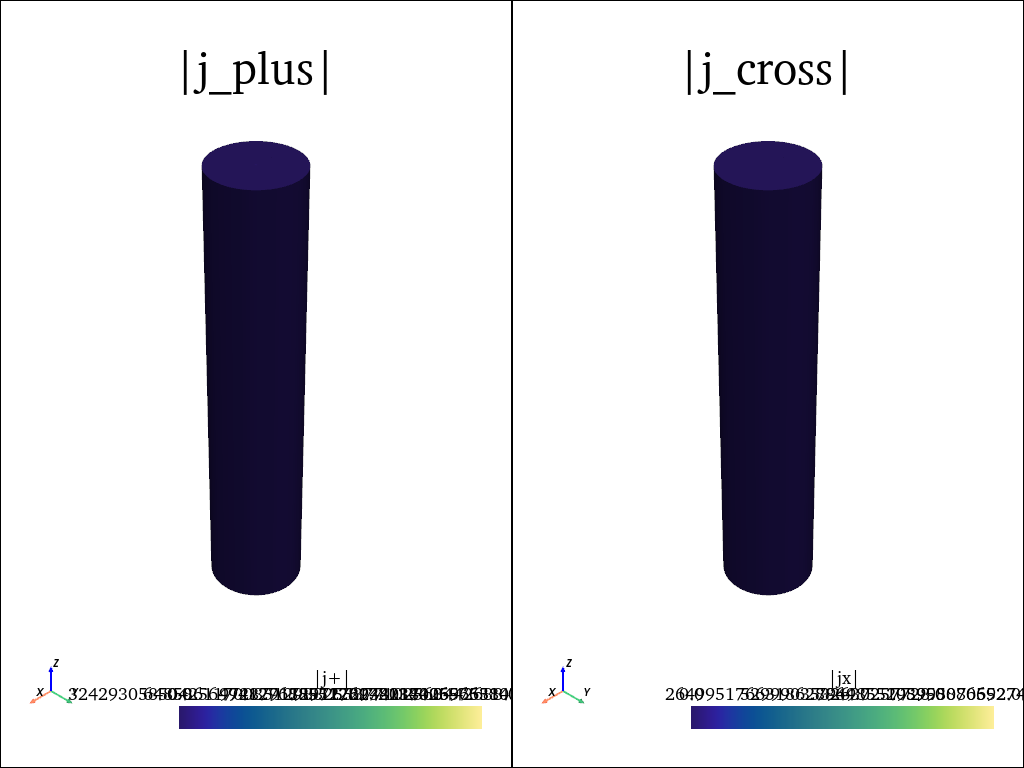

In [ ]:
beta_str = "pi_2"

plot_J(a, L, j_dir, beta_str, fig_dir, in_notebook=True)